# Mischief at the Airport Security

In this assignment, imagine you are a coop student working at an airport for the summer. You have been asked to cover a coworker's shift at the airport security, and coincidentally, on that day you meet a childhood friend who is planning to travel outside of the country. 
Unfortunately, it seems that your friend has some very suspicious items in their suitcases, and you are obliged to hold them back to analyze what is in their suitcases.
You noticed from the start that your friend had a strangely large number of suitcases, so you put them through a special scanner that shows you some scans of what's inside of them. You can take a look at the produced scans in the images included in the folder for this assignment, named `suspicious_suitcase#.png`.

You take a look, and, well...it's nothing violent. Yet still, you can't help but question your friendship choices as a child. 
Nonetheless, you decide to help out your friend. You brush up on your image processing skills, and agree to help distort the images to disguise the suspicious items found in your friend's suitcases. That is the goal of this lab.

We will begin by introducing you to the concept of 2D fourier transforms. The objective is for you to understand how to construct the basis functions, as well as analyze the magnitude spectrum and phase graphs of an image's FFT.

Then you will learn about the image processing libraries in python, and how different filters are applied to images, in either the frequency or the spatial domain.


Image effects:
- Blurring the image/Gaussian Smoothing 
- Grey Scale
- Phase swapping
- mean filter
- Laplacian Filter

Learning Goals:
- Identify properties of a filter through observing its effects on an image
- Be able to apply filters and image processing effect from more than one python library
- Recognize certain image properties through a magnitude graph of their FFT

In [1]:
# importing libraries for image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, filters

from scipy.signal import convolve2d

# you may have to install some of these
# if your environment does not recognize libraries, you can download them through a terminal using the command "pip install <lbrary name>"

## Part 1: Gaining Valuable Knowledge

Let us first become familiar with image processing, and how we can apply our knowledge of fourier transforms to manipulate and apply filters to 2D images.

Everything we've done so far with Fourier analysis can be extended to multi-dimensional signals. As a starting point, let's consider what this looks like in (discretized) continuous time. If a continuous-time signal is periodic, we can express it using a Fourier series. In 1D, this amounts to a linear combination of sines and cosines (or equivalently, of complex exponential signals) with integer multiples of a fundamental frequency:

$$
x(t) = \sum_{k=-\infty}^{\infty} c_k e^{jk\omega t} = a_0 + \sum_{k=1}^{\infty} a_k \cos(k \omega t) + \sum_{k=1}^{\infty} b_k \sin(k \omega t)
$$

The complex exponentials and trigonometric functions here serve as *basis functions*, as we are expressing everything in terms of them. 

In 2D, things are quite similar. Rather than expressing our signals as functions of time (since time is not 2D!), let's instead consider continuous-time signals as functions over space. We'll write them as $f(x, y)$. Just like in 1D, periodic signals in 2D can be expressed as linear combinations of complex exponentials (or trig functions, if you prefer), but now there are two of everything: 

$$
f(x, y) = \sum_{k=-\infty}^{\infty}\sum_{\ell=-\infty}^{\infty} c_{k,l}  \exp\left[j k \omega_x x\right] \exp\left[j \ell \omega_y y\right]
$$

In discrete time, for periodic signal $f[x, y]$ with dimensions $M \times N$, we have 

$$
f[x, y] = \sum_{k=0}^{M-1}\sum_{\ell=0}^{N-1} c_{k, \ell} \exp\left[j k \frac{2\pi}{M} x\right] \exp\left[j \ell \frac{2\pi}{N} y\right] 
$$

Let's start by simply playing with some basis functions.

**Exercise 1.0:** Fill in the function below to implement a function that constructs discretized versions of a single basis function.

In [2]:
def construct_2D_basis_function(k, M, l, N):
    """Create and return a 2D basis function with a given frequency. 
    
    This function should return a new function, f(x, y), such that 
        f(x, y) = exp(1j * k * (2 pi / M) * x) exp(1j * l * (2 pi / N) * y)
    
    Args:
        k (int): index of the harmonic in the x direction
        M (int): period of the signal in the x direction
        l (int): index of the harmonic in the y direction
        N (int): period of the signal in the y direction
        
    Returns:
        Callable: a function that implements the f(x, y) described above. 
        It should take two inputs, x and y, and return a single 
        complex number.
    """

    return basis_function

It might seem a bit odd to express our function in this way. However this will come in handy for what we are going to do next. 

**Exercise 1.1:** Construct and plot the real parts of the following basis functions evaluated on the grid of points provided below ($M=N=1000$): 
 - $k = 1$, $\ell = 0$
 - $k = 0$, $\ell = 1$
 - $k = 2$, $\ell = 3$
 - $k = 4$, $\ell = 6$

You can plot an array with `matplotlib` using the following code snippet:
```python
plt.matshow(my_matrix, cmap='gray')
```

*Pro tip*: with the provided grid, you should be able to do this without using any `for` loops!

In [3]:
# Here we are defining a range of x and y coordinates over which to
# evaluate the functions. I've set M and N to be reasonably small and
# equal, but you can make them larger.
M = 50
N = 50

x_range = np.arange(0, M)
y_range = np.arange(0, N)

# np.meshgrid will tile the arrays such that what comes back
# will be two grid 1000x1000 grids of points.
x_axis, y_axis = np.meshgrid(x_range, y_range)

In [4]:
#Use the spaces below to plot your basis function

In class, we computed the 1D discrete Fourier transform,

$$
\tilde{X}[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] e^{- j k \frac{2\pi}{N} n} 
$$

We saw that this is essentially a set of evenly-spaced samples of the more general discrete-time Fourier transform, which is a continuous function of frequency:

$$
X(e^{j\omega}) = \sum_{n=-\infty}^{\infty} x[n] e^{- j \frac{2\pi}{N} n} 
$$

The values of $X(e^{j\omega})$ and $\tilde{X}[k]$ tell us how much a particular frequency contributes to the signal.
This all generalizes to 2D. Suppose we have a 2D signal $f[x, y]$ with dimensions $M \times N$. Its discrete Fourier transform is given by

$$
\tilde{X}[k, l] = \frac{1}{M N} \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} f[x, y] e^{- j k \frac{2\pi}{M} m} e^{- j l \frac{2\pi}{N} n} 
$$

**Exercise 2.0:** 

(a) Compute the Fourier spectrum of some of the basis functions you made in the previous section (head over to the [NumPy docs](https://numpy.org/doc/stable/reference/routines.fft.html) (link opens in new tab) to find the right function for this purpose). 

(b) Apply a *shift* so that the lowest-valued frequencies are in the middle (this is done for visual convenience)

(c) Plot the *magnitude* of the spectrum. 

What do you see? Does this make sense?

In [5]:
# which function in the python library can you use to apply a shift?

In [6]:
# generate the plot here!

Feel free to play around with the above exercise. What would happen if you add two basis functions together and plot the FFT of their sum? Does the result make sense?

## Part 2: Greyscale Images and the Frequency Domain

Now let's take a quick look at how we upload and use the python libraries to analyze an image.

**Exercise 3.0:** For this part, we will upload a coloured image, choose one of the suspicious suitcases and use the skimage library to read the image into an array and plot the image array.

1. Search the `skimage`, `matplotlib.pyplot` or the `scipy.signal` libraries, find functions for the following tasks:
    - read an image into a 2D array
    - print the type and dimension of image (try using print() with different parameters)
    - plot the image

In [ ]:
# Take an image and put it into a 2D Array
# Read the image (Image should be in same folder as jupyter file, otherwise define a proper path to image)
img = ...

# Check the type of image
print(...)

# Check the Dimension of Image
print(...)

# Get the rows and columns of the image array
rows = img.shape[0]
cols = img.shape[1]

# Check the Values in the image
print(img)


# Plot the image
...

Before we use any python functions on the image, we must convert it to grayscale. The reason for this is that most functions in the python library only take in 2D arrays, but a coloured image is really a 3D array, with the 3rd "dimension" indicating the 3 different colour channels of the image. There is an R channel (red), B channel (blue) and G channel (green). 

Here is a visual of the colour channels that make up an image


As you can observe from the code block below, the `img` array is actually 3-dimensional! The 3rd "dimension" stores the colour channel information. So if you wish to view a single colour channel, you would input either 0, 1 or 2 into that last slot of `img[:,:,<here>]`. From the code below, you can guess that 0 is for the R channel, 1 is for the G channel, and 2 is for the B channel.


Text(0.5, 1.0, 'B channel')

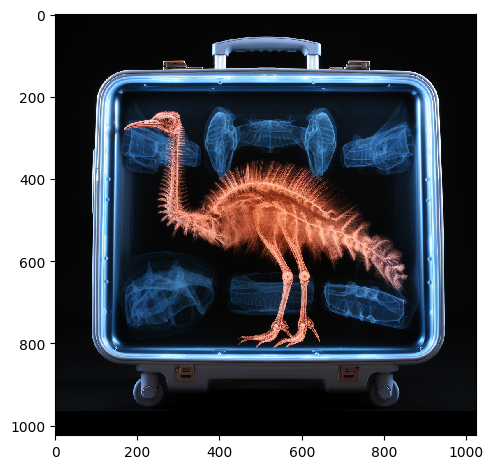

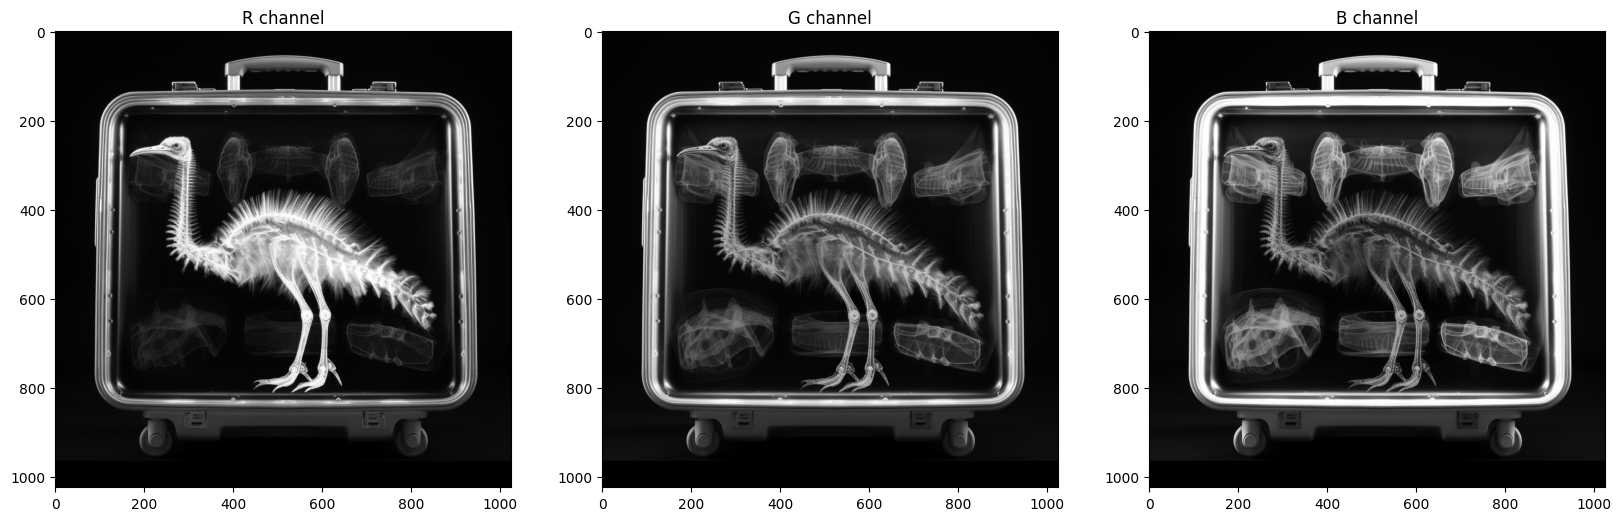

In [ ]:
# Note the dimensions of this image
img.shape
io.imshow(img)

# We will plot these in gray scale, otherwise the default matplotlib 
# cmap is yellow and purple
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
ax[0].imshow(img[:,:,0], cmap='gray')
ax[0].set_title("R channel")
ax[1].imshow(img[:,:,1], cmap='gray')
ax[1].set_title("G channel")
ax[2].imshow(img[:,:,2], cmap='gray')
ax[2].set_title("B channel")

#### Now that we're familiar with the grayscale imaging, let us analyze the images in the frequency domain.

When analyzing the FFT plot of a colored image, you can observe the following:

**Magnitude Distribution:** The height or color intensity of peaks in the FFT plot represents the magnitude or power of the frequency component. Higher peaks indicate the presence of dominant frequencies.

**Frequency Patterns:** The arrangement and patterns of peaks in the FFT plot provide information about the frequency content and structures present in the image. Regular patterns, lines, or clusters of peaks can indicate repeating patterns or structures in the image.

**Channel Separation:** If you analyze the FFT plots of each color channel separately, you can observe specific frequency components related to that channel. For example, the red channel may highlight specific frequency patterns related to red color intensity variations in the image.

**Cross-channel Relationships:** By comparing the FFT plots of different color channels, you can identify relationships and correlations between color channels and their frequency components. For example, you may observe similarities or differences in certain frequency ranges across channels.

**Exercise 3.1:** In the code box below, let's use a median filter that will help us blurr images! 

In [ ]:
# Let us first blurr our image and plot its fft and phase afterwards
# Blurred image - Mean filter
# This has the effect of eliminating the values of pixels that are not representative of their environment. 
# Mean filtering is generally thought of as a convolution filter.

grayscale_img = ... # Find a function in skimage that turns an RGB image into grayscale

blurred_image = filters.median(..., skimage.morphology.square(20))

# Plot the blurred image

Now let us plot the magnitude and phase plots of the blurred image and compare it to that of an image with more sharp edges.

In [ ]:
# take the Fourier Transform of the images

fft_img = ...

# shift the FT so that the DC component is in the center of the array (easier to analyze this way)
fft_img_shift = ...

mag_spectrum = ...   # magnitude of spectrum in dB
angle_spectrum = ...

fig = plt.figure()
fig.suptitle("Images after FT")

fig.add_subplot(1,2,1)
plt.imshow(abs(mag_spectrum), cmap="gray")
plt.title("Magnitude")
plt.colorbar()

fig.add_subplot(1,2,2)
plt.imshow(abs(angle_spectrum), cmap="gray")
plt.title("Phase")

In [ ]:

sharp_img_c = mpimg.imread('mickey.png') 
sharp_img = ... # Convert the image into grayscale

fft_img = ...

# shift the FT so that the DC component is in the center of the array (easier to analyze this way)
fft_img_shift = ...

mag_spectrum = ...   # magnitude of spectrum in dB
angle_spectrum = ...

fig = plt.figure()
fig.suptitle("Images after FT")

fig.add_subplot(1,2,1)
plt.imshow(abs(mag_spectrum), cmap="gray")
plt.title("Magnitude")
plt.colorbar()

fig.add_subplot(1,2,2)
plt.imshow(abs(angle_spectrum), cmap="gray")
plt.title("Phase")

Observe the results of taking the FFT and plotting the magnitude and phase plots for the blurry vs. the sharp images? What are some comparisons you can make?

## Part 3: Image Filtering Analysis

Time for a guessing game! Below you are provided 3 photos, each distorted using a different image processing technique.

**Exercise 4.0:** Your job is to analyze the different arrays in both time and frequency domains, and compare them to the original image to identify the patterns
of the filter that was applied. You do not have to name the specific filter used, but **bonus point** if you end up figuring out all 3 filters correctly!

Think about these distortions. Could they be helpful for your ultimate task of distorting the photos?

Notice how we are applying these filters on the original image, not on its FT.

**Note: Try playing around with the kernels. Keep their overall structure, but see how the image changes when you change the values in the matrix. That could be helpful when figuring out what effect is being used.**


**Take a look at these websites for some help with the next task:** 
 - https://en.wikipedia.org/wiki/Kernel_(image_processing)
 - https://cvexplained.wordpress.com/2020/04/30/kernels/

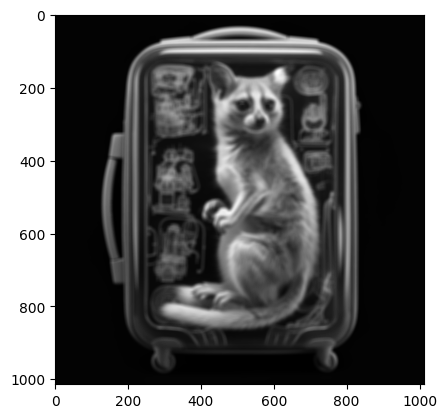

In [ ]:

image = mpimg.imread('suspicious_suitcase4.png') 
grimg = skimage.color.rgb2gray(image)
kernel_size = 11
f = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)

convolved = convolve2d(grimg, np.rot90(f), mode='valid')

#plot the image
plt.imshow(convolved, cmap="gray")


# print(grimg)
# print(convolved)

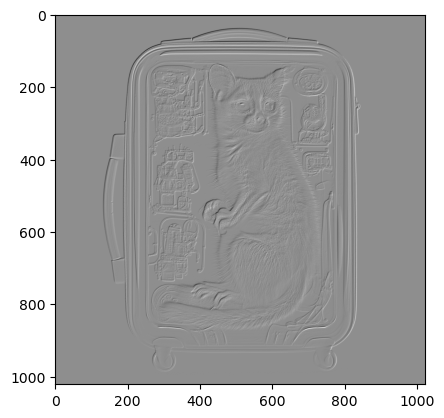

In [ ]:
# I wonder what this kernel does?
Kernel_1 = np.array([[0,-1,-1],[1,0,-1],[1,1,0]])

convolved2 = convolve2d(grimg, np.rot90(Kernel_1), mode='valid')

#plot the image
plt.imshow(convolved2, cmap="gray")

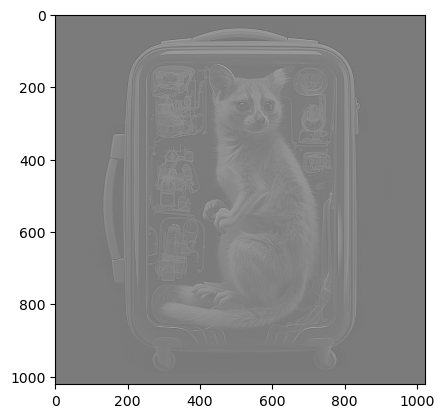

In [ ]:
# What about this one???
Kernel_2 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

convolved3 = convolve2d(grimg, np.rot90(Kernel_2), mode='valid')

#plot the image
plt.imshow(convolved3, cmap="gray")

## Part 4: Applying Filters to Images

Now let's disguise our image so that our friend makes it through security without being caught!

**Exercise 5.0:**
We will design a few filters that will distort our images. Below we guide you through two ways to distort your image, but <font color='red'><font size=5> you will have to add **two** additional filters</font></font> to the given techniques below, to make sure your image is fully disguised. You can look through the python libraries you imported in this assignment and use some of their functions for the distortions, just make sure to specify what you are using in your code.

Any new code that you write, an your final image, add those at the very bottom of the assignment. Just add a new code box and paste everything in there!


For the first filter, let us construct a **butterworth filter** that will blurr a coloured image. Make sure you pass a coloured image when you use this function!

In [ ]:
# Let's make a butterworth filter

def apply_butterworth_filter(image, cutoff_frequency_ratio=0.01, high_pass=False, order=1):
    """Apply a Butterworth filter to a colour image. 
    
    This function should wrap the skimage.filters.butterworth function 
    so that it is applied to each channel of the image individually, and
    then the reconstructed image returned.
    
    Args:
        image (array): Array representing a multi-channel image.
        cutoff_frequency_ratio (float): Indicates the position of the frequency
            cutoff as a percentage of the length of the spectrum.
        high_pass (bool): If True, will act as a highpass filter. Otherwise, it
            will be a lowpass filter.
        order (float): The order of the filter; how quickly the frequency 
            response drops to 0.
            
    Returns:
        array: A multi-channel image that has had the Butterworth filter
        applied to each channel indepedently.
    """
    # Set up a NumPy array of the same size as the image
        
    return filtered_image

In [ ]:
# Apply the Butterworth filter to one of the suitcase images we've included 
image = ...
butterworth_img = ...

# Plot the image
...

Now let's make a function that can the swap phases of two images, and plot them to see how much distortion that adds to the image.

Write a function `swap_phase` that takes as argument two complex numbers $z_1$ and $z_2$ and returns complex numbers $z_3$ and $z_4$, such that 
$$
|z_3| = |z_1|,~~\rm{arg}(z_3) = \rm{arg}(z_2),
$$
and 
$$
|z_4| = |z_2|,~~\rm{arg}(z_4) = \rm{arg}(z_1).
$$

Note: If you are using this after applying the butterworth filter above, make sure you convert that image to grayscale, as swapping phases on a coloured image will give a different result. Why do you think this happens?

You may need to use the following function that converts polar to cartesian coordinates.

In [10]:
def pol2cart(rho, phi): # How would we get the x and y coordinates here?
    x = ...
    y = ...
    z = x + y*1j
    return z

Now use the function `pol2cart` to define the function `swap_phase`.

In [8]:
# Now, let's make a phase swap of the two images
# Make it so that z1 has the phase of z2, and vice versa

def swap_phase(z1,z2):
    z3 = ...
    z4 = ...
    
    return (z3,z4)

Use the function that you defined above to swap the phases of FT1 and FT2. Then, call the inverse fourier transform on the new Fourier transform arrays. Plot the new images. What do you observe?

In [ ]:
# load the two images
img1 = mpimg.imread('suspicious_suitcase3.png') 
img2 = mpimg.imread('suspicious_suitcase4.png') 

# Turn the images into grayscale
grimg1 = skimage.color.rgb2gray(img1)
grimg2 = skimage.color.rgb2gray(img2)

FT1 = np.fft.fft2(grimg1)
FT1 = np.fft.fftshift(FT1)
FT2 = np.fft.fft2(grimg2)
FT2 = np.fft.fftshift(FT2)

# plot the two images
fig = plt.figure()
fig.suptitle("Original images")

fig.add_subplot(1,2,1)
plt.imshow(abs(img1), cmap="gray")
plt.title("Person")

fig.add_subplot(1,2,2)
plt.imshow(abs(img2), cmap="gray")
plt.title("Cat")

# ************************** #
# swap phases
# ************************** #
(FT1_new,FT2_new) = swap_phase(FT1,FT2)  # swap phases

# compute the *inverse* Fourier transforms of the images
img1_new = np.fft.ifft2(FT1_new)
img2_new = np.fft.ifft2(FT2_new)

fig = plt.figure()
fig.suptitle("Images after inverse FT")

fig.add_subplot(1,2,1)
plt.imshow(abs(img1_new), cmap="gray")
plt.title("Image 1")

fig.add_subplot(1,2,2)
plt.imshow(abs(img2_new), cmap="gray")
plt.title("Image 2")

Implement your two new filters below!

In [ ]:
# Filter 1

In [ ]:
# Filter 2

In [ ]:
# Fully Disguised Image (some combo of multiple filters)